<a href="https://colab.research.google.com/github/yanabasharova04-lab/neironie_seti/blob/main/progectNNready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
with ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile

In [12]:
def get_class_name(class_id):
    class_names = {
        0: 'Нормальный ритм',
        1: 'Предсердная premature contraction',
        2: 'Преждевременное сокращение желудочков',
        3: 'Fusion ventricular and normal',
        4: 'Не классифицируемое сокращение'
    }
    return class_names.get(class_id, f'Неизвестный класс {class_id}')

In [13]:
def load_real_data():
    print("Загрузка реальных данных...")

    train_df = pd.read_csv('/content/mitbih_train.csv', header=None)
    test_df = pd.read_csv('/content/mitbih_test.csv', header=None)

    print(f"Тренировочные данные: {train_df.shape}")
    print(f"Тестовые данные: {test_df.shape}")

    return train_df, test_df


train_df, test_df = load_real_data()

Загрузка реальных данных...
Тренировочные данные: (87554, 188)
Тестовые данные: (21892, 188)


In [14]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Форма данных после преобразования:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Форма данных после преобразования:
X_train: (87554, 187, 1), y_train: (87554,)
X_test: (21892, 187, 1), y_test: (21892,)


In [15]:
print("Распределение классов в тренировочных данных:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Класс {cls} ({get_class_name(cls)}): {count} samples ({count/len(y_train)*100:.1f}%)")

Распределение классов в тренировочных данных:
Класс 0.0 (Нормальный ритм): 72471 samples (82.8%)
Класс 1.0 (Предсердная premature contraction): 2223 samples (2.5%)
Класс 2.0 (Преждевременное сокращение желудочков): 5788 samples (6.6%)
Класс 3.0 (Fusion ventricular and normal): 641 samples (0.7%)
Класс 4.0 (Не классифицируемое сокращение): 6431 samples (7.3%)


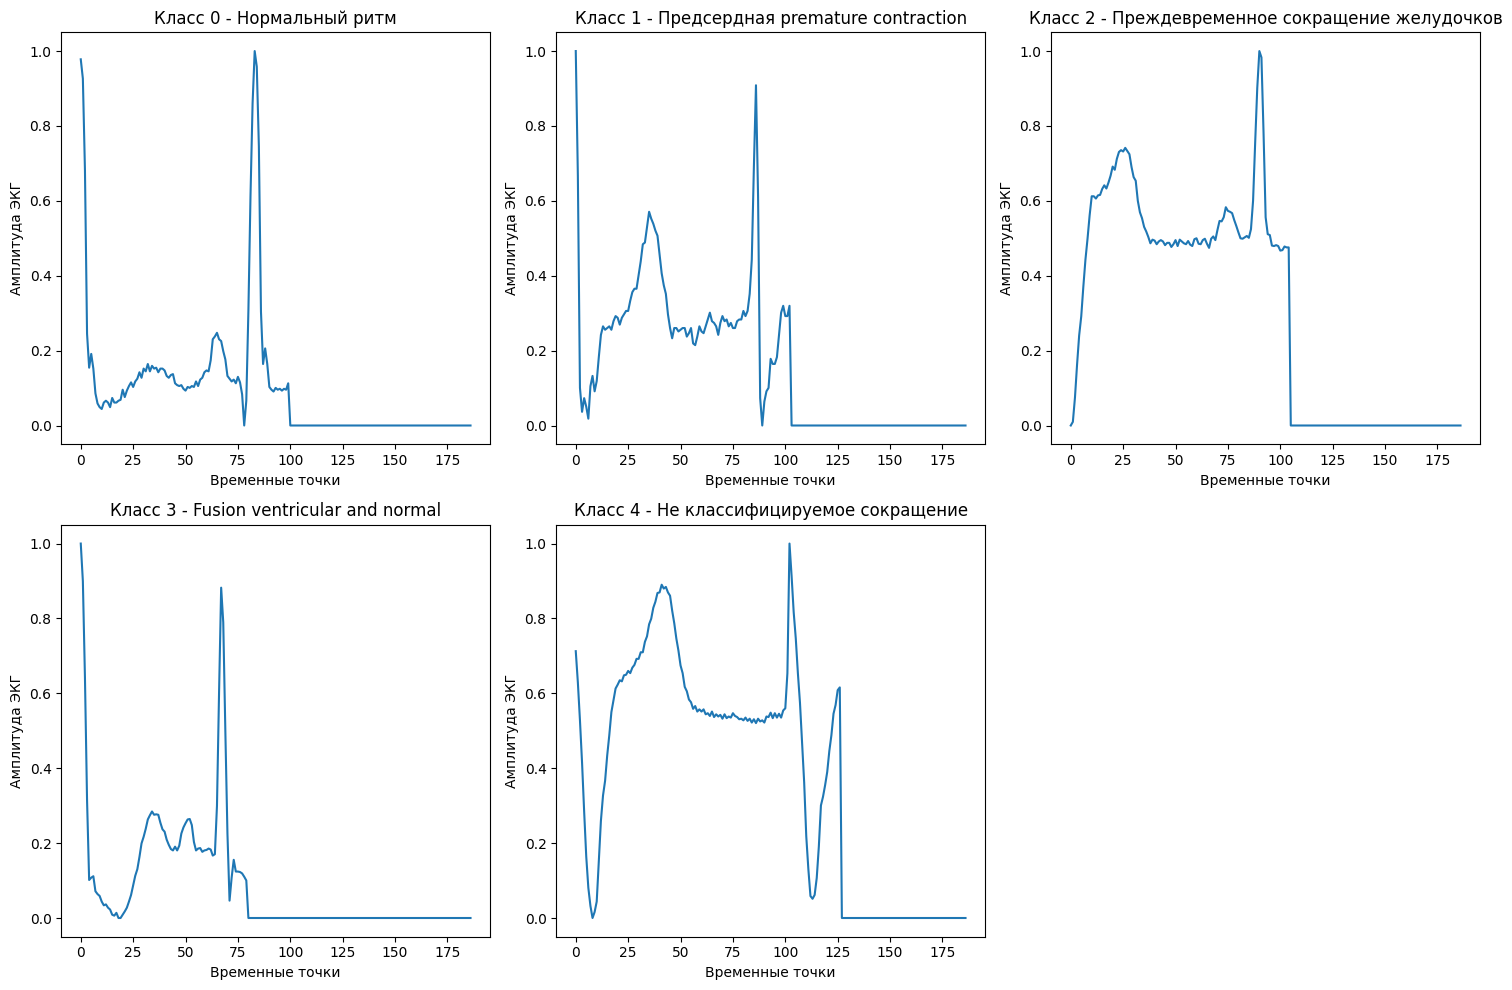

In [16]:
plt.figure(figsize=(15, 10))
for class_id in range(5):
    plt.subplot(2, 3, class_id + 1)


    class_indices = np.where(y_train == class_id)[0]
    if len(class_indices) > 0:
        sample_idx = class_indices[0]
        plt.plot(X_train[sample_idx, :, 0])
        plt.title(f'Класс {class_id} - {get_class_name(class_id)}')
        plt.xlabel('Временные точки')
        plt.ylabel('Амплитуда ЭКГ')
plt.tight_layout()
plt.show()

In [17]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),


    layers.Conv1D(32, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.Flatten(),


    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 183, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 89, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       360,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,557 (1.43 MB)

 Trainable params: 375,557 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.8840 - loss: 0.4391 - val_accuracy: 0.9519 - val_loss: 0.1680
Epoch 2/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9496 - loss: 0.1855 - val_accuracy: 0.9633 - val_loss: 0.1305
Epoch 3/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9593 - loss: 0.1468 - val_accuracy: 0.9688 - val_loss: 0.1096
Epoch 4/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.9626 - loss: 0.1398 - val_accuracy: 0.9717 - val_loss: 0.0975
Epoch 5/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9682 - loss: 0.1171 - val_accuracy: 0.9741 - val_loss: 0.0906
Epoch 6/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9705 - loss: 0.1074 - val_accuracy: 0.9762 - val_loss: 0.0858
Epoch 7/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9704 - loss: 0.1029 - val_accuracy: 0.9767 - val_loss: 0.0841
Epoch 8/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9745 -

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Точность на тестовых данных: {test_accuracy:.4f}")

Точность на тестовых данных: 0.9790


In [20]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Отчет о классификации:")
print(classification_report(y_test, y_pred_classes, target_names=[get_class_name(i) for i in range(5)]))

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Отчет о классификации:
                                       precision    recall  f1-score   support

                      Нормальный ритм       0.98      1.00      0.99     18118
    Предсердная premature contraction       0.94      0.63      0.75       556
Преждевременное сокращение желудочков       0.96      0.92      0.94      1448
        Fusion ventricular and normal       0.84      0.67      0.75       162
       Не классифицируемое сокращение       0.99      0.98      0.99      1608

                             accuracy                           0.98     21892
                            macro avg       0.94      0.84      0.88     21892
                         weighted avg       0.98      0.98      0.98     21892

